In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Aggregation of Statements and Processing

In [ ]:
accs = [f for f in os.listdir('./') if (os.path.isdir(os.path.join('./', f)) and f != '__pycache__')]

for acc in accs:
    try:
        if acc == "TD Credit":
            stmts = [stmt for stmt in os.listdir(os.path.join('./', acc))]
            agg_stmt = pd.read_csv(''.join(('./', acc, '/', stmts[0])))
            if len(stmts) > 1:
                for stmt in stmts[1:]:
                    temp = pd.read_csv(''.join(('./', acc, '/', stmt)))
                    temp.columns = agg_stmt.columns
                    agg_stmt = pd.concat([agg_stmt, temp], ignore_index=True)
            agg_stmt.to_csv(''.join(('./', acc, '.csv')), index=False)
        elif acc == "Canadian Tire":
            mdr = 3 # rows of metadata
            stmts = [stmt for stmt in os.listdir(os.path.join('./', acc))]
            agg_stmt = pd.read_csv(''.join(('./', acc, '/', stmts[0])), skiprows=mdr)
            if len(stmts) > 1:
                for stmt in stmts[1:]:
                    try:
                        temp = pd.read_csv(''.join(('./', acc, '/', stmt)), skiprows=mdr)
                        agg_stmt = pd.concat([agg_stmt, temp])
                    except Exception as E:
                        print(f"Error with Statement {stmt} in Account {acc}: {E}")
            agg_stmt.to_csv(''.join(('./', acc, '.csv')), index=False)
        else:
            stmts = [stmt for stmt in os.listdir(os.path.join('./', acc))]
            agg_stmt = pd.read_csv(''.join(('./', acc, '/', stmts[0])))
            if len(stmts) > 1:
                for stmt in stmts[1:]:
                    try:
                        temp = pd.read_csv(''.join(('./', acc, '/', stmt)))
                        agg_stmt = pd.concat([agg_stmt, temp])
                    except Exception as E:
                        print(f"Error with Statement {stmt} in Account {acc}: {E}")
            agg_stmt.to_csv(''.join(('./', acc, '.csv')), index=False)
    except Exception as E:
        print(f"Error with Account {acc}: {E}")


In [8]:
# Process credit cards
ct = pd.read_csv('./Canadian Tire.csv')
ct["Account"] = "Canadian Tire Mastercard"
ct["AmountIn"] = np.where(ct["AMOUNT"] < 0, ct["AMOUNT"]*-1, 0)
ct["AmountOut"] = np.where(ct["AMOUNT"] >= 0, ct["AMOUNT"], 0)
ct = ct.rename(columns={"TRANSACTION DATE": "Date", "DESCRIPTION": "Description"})
ct["Date"] = pd.to_datetime(ct['Date'])
ct = ct[["Account", "Date", "Description", "AmountIn", "AmountOut"]]

pc = pd.read_csv('./PC Financial.csv')
pc["Account"] = "PC Financial Mastercard"
pc["AmountIn"] = np.where(pc["Amount"] >= 0, pc["Amount"], 0)
pc["AmountOut"] = np.where(pc["Amount"] < 0, pc["Amount"]*-1, 0)
pc = pc[["Account", "Date", "Description", "AmountIn", "AmountOut"]]

sfv = pd.read_csv('./Simplii Credit.csv')
sfv["Account"] = "Simplii Financial Visa"
sfv = sfv.rename(columns={" Transaction Details": "Description", " Funds Out": "AmountOut", " Funds In": "AmountIn"})
sfv = sfv[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

tdv = pd.read_csv('./TD Credit.csv')
tdv["Account"] = "TD Visa"
tdv = tdv.rename(columns={"Debit": "AmountOut", "Credit": "AmountIn"})
tdv = tdv[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

tgm = pd.read_csv('./Tangerine Credit.csv')
tgm["Account"] = "Tangerine Mastercard"
tgm["AmountIn"] = np.where(tgm["Amount"] >= 0, tgm["Amount"], 0)
tgm["AmountOut"] = np.where(tgm["Amount"] < 0, tgm["Amount"]*-1, 0)
tgm = tgm.rename(columns={"Transaction date": "Date", "Name": "Description"})
tgm = tgm[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

# Process chequing accounts
tgc = pd.read_csv('./Tangerine Chequing.csv')
tgc["Account"] = "Tangerine Chequing"
tgc["AmountIn"] = np.where(tgc["Amount"] >= 0, tgc["Amount"], 0)
tgc["AmountOut"] = np.where(tgc["Amount"] < 0, tgc["Amount"]*-1, 0)
tgc = tgc.rename(columns={"Name": "Description"})
tgc = tgc[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

tdc = pd.read_csv('./TD Chequing.csv')
tdc["Account"] = "TD Chequing"
tdc = tdc[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

sfc = pd.read_csv('./Simplii Chequing.csv')
sfc["Account"] = "Simplii Chequing"
sfc = sfc.rename(columns={" Transaction Details": "Description", " Funds Out": "AmountOut", " Funds In ": "AmountIn"})
sfc = sfc[["Account", "Date", "Description", "AmountIn", "AmountOut"]].fillna(0)

In [9]:
agg_acc = ct
agg_acc = pd.concat([agg_acc, pc, sfv, tdv, tgm, tgc, tdc, sfc])
agg_acc["Date"] = pd.to_datetime(agg_acc['Date'])
agg_acc["Description"] = agg_acc["Description"].str.replace(r'\s\s+', ' ', regex=True).str.strip()


## Binning 
Previously categorized into Investments, Productivity, Material Desires, Health and Vanity, Necessities, Education, Food, Recreation, and Donations
Now
- Investments
- Groceries
- Liquor
- Restaurants
- Rent & Utilities
- Education
- Transfers
- Health
- Recreation
- Shopping
- Travel
- Home & Office
- Tech

In [34]:
agg_acc["Category"] = np.nan
import imp
import bin
imp.reload(bin)

# Manual Binning

binned_agg = bin.bin(agg_acc)

final = binned_agg[["Category", "Date", "AmountIn", "AmountOut"]]
final.sort_values(by='Date', inplace=True)
final.reset_index(drop=True, inplace=True)
final.to_excel('./Final.xlsx')
# This is called each time to help visualize what else is left to be binned.
empty = binned_agg.loc[(binned_agg['Category'].isna()) | (binned_agg['Category'] == 'Misc')]
empty['AmountOut'] = empty['AmountOut'].astype('float')
empty['AmountIn'] = empty['AmountIn'].astype('float')

# empty.nlargest(50, 'AmountOut')
# final.loc[final['Category'] == 'Home & Office']
# binned_agg.loc[binned_agg['Description'].str.contains('IKEA', case=False)]

utilities_education = binned_agg.loc[(binned_agg['Category'] == 'Rent & Utilities') | (binned_agg['Category'] == 'Education')]
utilities_education

empty.nlargest(50, 'AmountIn')

,Account,Date,Description,AmountIn,AmountOut,Category
288,TD Chequing,2023-05-04,230504S9086900WIRE,495.40,0.0,Misc
244,TD Chequing,2023-02-16,IQ435 TFR-FR 6758465,31.50,0.0,Misc
328,TD Chequing,2023-06-16,230616S0345800WIRE,27.26,0.0,Misc
52,TD Chequing,2022-06-15,SEND E-TFR ***E5q,0.00,13.0,Misc


## Monthy Income and Outcome Analysis

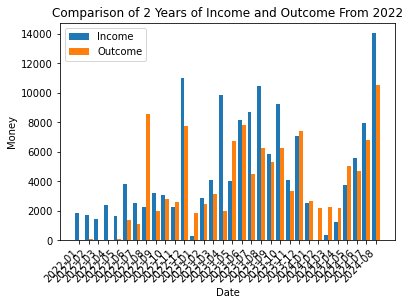

In [6]:
ia = binned_agg.copy(True)

ia['Date'] = ia['Date'].dt.strftime('%Y-%m')
ia = ia[(ia['Category'] != 'Loans') & 
        (ia['Category'] != 'Investments') & 
        (ia['Category'] != 'Transfers') &
        (ia['Category'] != 'Reimbursements')][['Date', "AmountIn", "AmountOut"]].groupby('Date').agg('sum')


X = ia.index
income = ia['AmountIn'].to_numpy()
outcome = ia['AmountOut'].to_numpy()
  
X_axis = np.arange(len(X))
fig1, ax = plt.subplots()
plt.bar(X_axis - 0.2, income, 0.4, label = 'Income')
plt.bar(X_axis + 0.2, outcome, 0.4, label = 'Outcome')
  
plt.xticks(X_axis, X)
plt.xticks(rotation = 45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.xlabel("Date")
plt.ylabel("Money")
plt.title("Comparison of 2 Years of Income and Outcome From 2022")
plt.legend()
plt.show()

In [7]:
final2 = binned_agg
final2.sort_values(by='Date', inplace=True)
final2.reset_index(drop=True, inplace=True)
final2.to_excel('./FinalwTransactionNames.xlsx')